# **KNN Model**

In [11]:
def knn_cv(df,n,size, markersize):
    train_x, test_x, train_y, test_y = data_split(df)
    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

    best_k = -1
    best_score = -1
    for k in [1,2,3,5,7,9,15,31,51,train_x_scaled.shape[0]]:
        knn = KNeighborsClassifier(n_neighbors=k)

        cv_result = cross_validate(knn, train_x_scaled, train_y, cv=n ,scoring='accuracy',n_jobs=-1, return_train_score = True)
        train_score = np.mean(cv_result['train_score'])
        val_score = np.mean(cv_result['test_score'])

        knn_model = knn.fit(train_x_scaled, train_y)
        print("k:", k, "Training Score:", train_score, "Validation Score: ", val_score)

        if best_score <= val_score:
            best_score = val_score
            best_model = knn_model
            best_k = k

    test_y_pred = best_model.predict(test_x_scaled)
    tn, fp, fn, tp = confusion_matrix(test_y, test_y_pred).ravel()
    print(f'The best k is {best_k} and the best val score is {best_score:.4f}')

    print("Training Score: {:.4f}".format(best_model.score(train_x_scaled, train_y)),
    "\n Test Score: {:.4f}".format(best_model.score(test_x_scaled, test_y)))
    print("Testing: Sensitivity:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

In [14]:
knn_cv(df, 5, 100, 1)

k: 1 Training Score: 1.0 Validation Score:  0.6856723977075836
k: 2 Training Score: 0.8326544467074 Validation Score:  0.6889244302279088
k: 3 Training Score: 0.8489369628930504 Validation Score:  0.7052245768359323
k: 5 Training Score: 0.8074073154173498 Validation Score:  0.7182327069172331
k: 7 Training Score: 0.789905287036577 Validation Score:  0.7133946421431429
k: 9 Training Score: 0.7890914509959763 Validation Score:  0.7133679861388778
k: 15 Training Score: 0.7780967992979319 Validation Score:  0.7296947887511662
k: 31 Training Score: 0.7552977994138393 Validation Score:  0.7248034119685459
k: 51 Training Score: 0.7483748116503568 Validation Score:  0.7410769025723044
k: 614 Training Score: nan Validation Score:  nan
The best k is 51 and the best val score is 0.7411
Training Score: 0.7541 
 Test Score: 0.7987
Testing: Sensitivity: 0.46808510638297873 Specificity: 0.9439252336448598


# **XAI for KNN:**

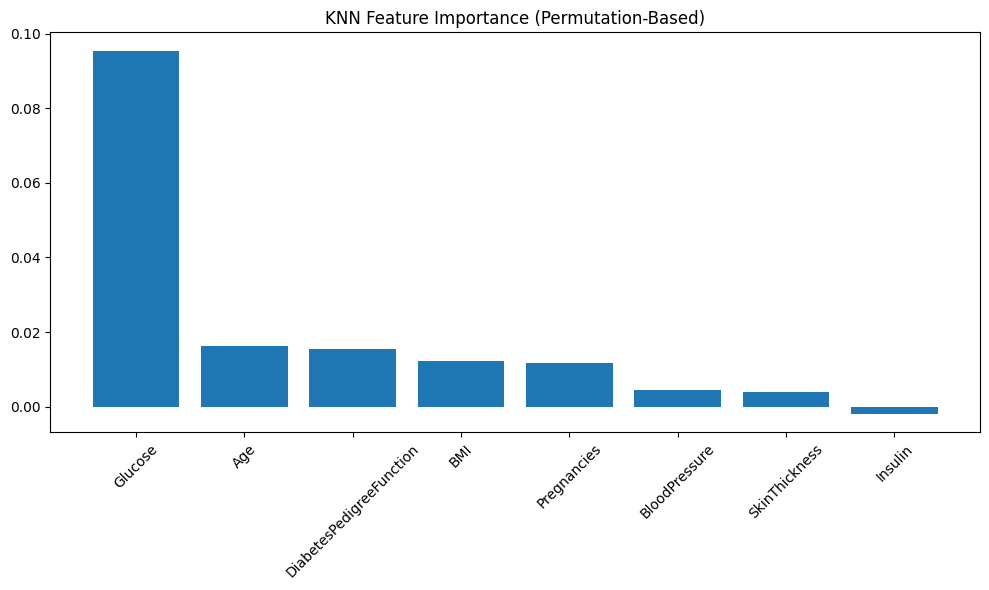

In [42]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

train_x, test_x, train_y, test_y = data_split(df)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
best_k = 51
best_model = KNeighborsClassifier(n_neighbors=best_k).fit(train_x_scaled, train_y)
result = permutation_importance(best_model, test_x_scaled, test_y, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()[::-1]

try:
    feature_names = train_x.columns
except:
    feature_names = [f"F{i}" for i in range(train_x_scaled.shape[1])]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.xticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], rotation=45)
plt.title("KNN Feature Importance (Permutation-Based)")
plt.tight_layout()
plt.show()

# **ConvLSTM Model**

In [15]:
def reshape_for_convlstm(X, time_steps=1):
    n_samples, n_features = X.shape
    side = int(np.ceil(np.sqrt(n_features)))
    padded = np.zeros((n_samples, side * side))
    padded[:, :n_features] = X
    reshaped = padded.reshape((n_samples, time_steps, side, side, 1))
    return reshaped

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, Dropout, BatchNormalization

def build_convlstm_model(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=32, kernel_size=(3,3), activation='relu',
                         input_shape=input_shape, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [17]:
def train_convlstm(df):
    train_x, test_x, train_y, test_y = data_split(df)
    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
    train_x_reshaped = reshape_for_convlstm(train_x_scaled)
    test_x_reshaped = reshape_for_convlstm(test_x_scaled)
    model = build_convlstm_model(train_x_reshaped.shape[1:])
    history = model.fit(train_x_reshaped, train_y, epochs=20, batch_size=32,
                        validation_data=(test_x_reshaped, test_y), verbose=1)
    test_loss, test_acc = model.evaluate(test_x_reshaped, test_y)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    return model

In [18]:
model = train_convlstm(df)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4916 - loss: 0.6872 - val_accuracy: 0.6948 - val_loss: 0.6676
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7319 - loss: 0.5605 - val_accuracy: 0.6948 - val_loss: 0.6417
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7203 - loss: 0.5285 - val_accuracy: 0.6948 - val_loss: 0.6223
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7761 - loss: 0.4883 - val_accuracy: 0.6948 - val_loss: 0.6129
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7434 - loss: 0.4836 - val_accuracy: 0.6948 - val_loss: 0.6031
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7719 - loss: 0.4514 - val_accuracy: 0.7013 - val_loss: 0.5936
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7413 - loss: 0.4849 - val_accuracy: 0.7013 - val_loss: 0.5869
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7654 - loss: 0.4599 - val_accuracy: 0.7013 - val_loss

# **XAI for ConvLSTM:**

In [48]:
train_x, test_x, train_y, test_y = data_split(df)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

train_x_reshaped = reshape_for_convlstm(train_x_scaled)
test_x_reshaped = reshape_for_convlstm(test_x_scaled)

In [53]:
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_saliency_map(model, input_sample, class_index=0)
    input_tensor = tf.convert_to_tensor(input_sample[None, ...])
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        preds = model(input_tensor, training=False)
        output = preds[:, class_index] if preds.shape[1] > 1 else preds
    grads = tape.gradient(output, input_tensor)[0]
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()
    saliency_avg = np.mean(saliency, axis=0)

    plt.imshow(saliency_avg, cmap='hot')
    plt.title("Saliency Map (Averaged Over Time)")
    plt.colorbar()
    plt.show()

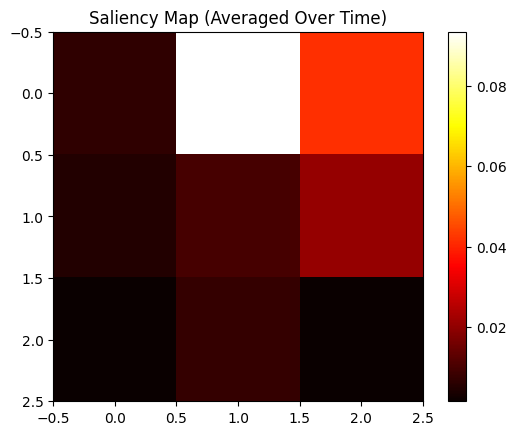

In [54]:
sample = test_x_reshaped[0]
plot_saliency_map(model, sample)

# **ANN Model**

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_ann_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [20]:
def train_ann(df):
    train_x, test_x, train_y, test_y = data_split(df)
    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
    model = build_ann_model(train_x_scaled.shape[1])
    history = model.fit(train_x_scaled, train_y, epochs=50, batch_size=32,
                        validation_data=(test_x_scaled, test_y), verbose=1)
    test_loss, test_acc = model.evaluate(test_x_scaled, test_y)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    return model, history

In [21]:
ann_model, ann_history = train_ann(df)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6100 - loss: 0.7860 - val_accuracy: 0.7662 - val_loss: 0.6237
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7340 - loss: 0.5727 - val_accuracy: 0.8182 - val_loss: 0.5710
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7480 - loss: 0.5348 - val_accuracy: 0.8247 - val_loss: 0.5463
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7658 - loss: 0.5352 - val_accuracy: 0.8117 - val_loss: 0.5393
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7387 - loss: 0.5480 - val_accuracy: 0.8052 - val_loss: 0.5307
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7681 - loss: 0.4783 - val_accuracy: 0.8312 - val_loss: 0.5165
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7699 - loss: 0.5192 - val_accuracy: 0.8117 - val_loss: 0.5062
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7879 - loss: 0.4550 - val_accuracy: 0.7987 - val_loss

# **XAI for ANN:**

ExactExplainer explainer: 155it [00:13,  6.31it/s]                         


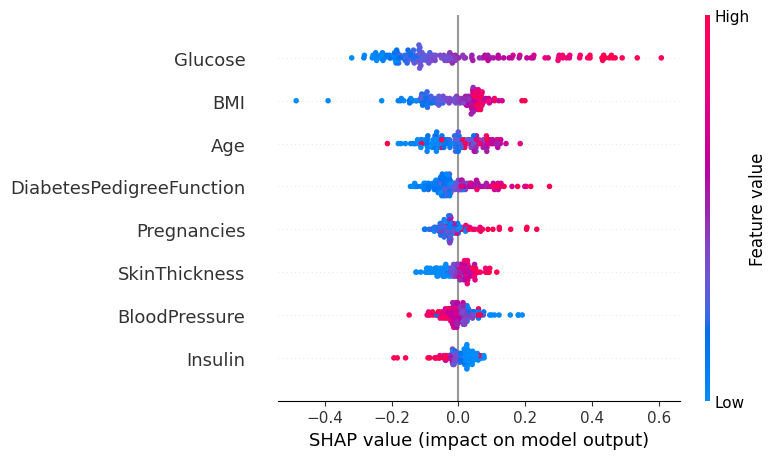

In [43]:
import shap
import numpy as np
train_x, test_x, train_y, test_y = data_split(df)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
explainer_ann = shap.Explainer(ann_model, train_x_scaled)
shap_values_ann = explainer_ann(test_x_scaled)
shap.summary_plot(shap_values_ann, test_x_scaled, feature_names=train_x.columns)